# 0 Imports

In [9]:
import datetime
import logging

import dataflow.model as dtfmod
import helpers.hdbg as hdbg
import helpers.henv as henv
import helpers.hpandas as hpandas
import reconciliation as reconcil

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
hdbg.init_logger(verbosity=logging.INFO)

_LOG = logging.getLogger(__name__)

_LOG.info("%s", henv.get_system_signature()[0])

hprint.config_notebook()

-----------------------------------------------------------------------------
This code is not in sync with the container:
code_version='1.4.3' != container_version='1.4.0'
-----------------------------------------------------------------------------
You need to:
- merge origin/master into your branch with `invoke git_merge_master`
- pull the latest container with `invoke docker_pull`
INFO  # Git
  branch_name='CmTask4085_Create_a_dash_plotly_web_app_to_serve_PnL_graphs'
  hash='04891460b'
  # Last commits:
    * 04891460b jsmerix  Apply changes to make deployment to ECS easier                    (    2 days ago) Sun May 21 19:35:37 2023  (HEAD -> CmTask4085_Create_a_dash_plotly_web_app_to_serve_PnL_graphs, origin/CmTask4085_Create_a_dash_plotly_web_app_to_serve_PnL_graphs)
    * e946bbb45 vlady    CmTask4085: try to get 2019 data                                  (    2 days ago) Sun May 21 14:56:14 2023           
    * aa3859f1b vlady    CmTask4085: playing around 2019 and 2022      

NameError: name 'hprint' is not defined

# Current and yesterday

In [18]:


# Load portfolio stats.
portfolio_dir = "/shared_data/ecs/preprod/system_reconciliation/C1b/20230512/system_log_dir.scheduled.20230512_131000.20230513_130500/process_forecasts/portfolio"
_, stats_df = reconcil.load_portfolio_artifacts(portfolio_dir)
# Compute cumulative PnL.
cumulative_pnl = stats_df["pnl"].cumsum()

Loading `holdings_shares` files...:   0%|          | 0/40 [00:00<?, ?it/s]

Loading `holdings_notional` files...:   0%|          | 0/40 [00:00<?, ?it/s]

Loading `executed_trades_shares` files...:   0%|          | 0/40 [00:00<?, ?it/s]

Loading `executed_trades_notional` files...:   0%|          | 0/40 [00:00<?, ?it/s]

Loading `statistics` files...:   0%|          | 0/40 [00:00<?, ?it/s]

In [19]:
import pandas as pd

pd.Series(cumulative_pnl.index).agg(["min", "max"])

min   2023-05-12 09:10:26.885080-04:00
max   2023-05-12 12:25:29.066000-04:00
dtype: datetime64[ns, America/New_York]

In [21]:
len(cumulative_pnl)

40

In [22]:
cumulative_pnl

2023-05-12 09:10:26.885080-04:00         NaN
2023-05-12 09:15:27.809574-04:00    0.000000
2023-05-12 09:20:27.916222-04:00    0.011590
2023-05-12 09:25:27.824705-04:00    0.412628
2023-05-12 09:30:27.476925-04:00    1.284630
2023-05-12 09:35:28.217933-04:00    1.513002
2023-05-12 09:40:28.123337-04:00    1.131088
2023-05-12 09:45:28.153602-04:00    1.360020
2023-05-12 09:50:28.140456-04:00    1.302930
2023-05-12 09:55:28.123882-04:00    1.885242
2023-05-12 10:00:28.041807-04:00    1.177472
2023-05-12 10:05:28.272136-04:00   -1.388858
2023-05-12 10:10:27.604003-04:00   -1.800218
2023-05-12 10:15:27.666166-04:00   -1.924870
2023-05-12 10:20:28.133223-04:00   -2.232368
2023-05-12 10:25:28.233470-04:00   -4.023156
2023-05-12 10:30:27.877971-04:00   -2.098846
2023-05-12 10:35:28.297183-04:00   -3.937118
2023-05-12 10:40:28.470814-04:00   -4.592824
2023-05-12 10:45:28.689129-04:00   -2.565432
2023-05-12 10:50:28.060867-04:00   -4.562436
2023-05-12 10:55:28.329841-04:00   -3.717878
2023-05-12

<AxesSubplot: >

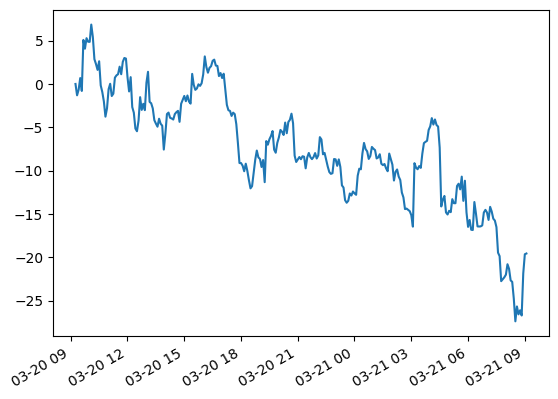

In [3]:
cumulative_pnl.plot()

# since 2022 and since 2019

In [2]:
dir_name = "/shared_data/model/historical/pnl_for_website/build_tile_configs.C3a.ccxt_v7_1-all.5T.2019-09-01_2023-05-15.ins/tiled_results/"
start_date = datetime.date(2019, 9, 1)
end_date = datetime.date(2023, 5, 15)
asset_id_col = "asset_id"
data_cols = {
    "price": "vwap",
    "volatility": "garman_klass_vol",
    "prediction": "feature",
}
data_cols_list = list(data_cols.values())
iter_ = dtfmod.yield_processed_parquet_tiles_by_year(
    dir_name,
    start_date,
    end_date,
    asset_id_col,
    data_cols_list,
    asset_ids=None,
)
df_res = hpandas.get_df_from_iterator(iter_)

  0%|          | 0/5 [00:00<?, ?it/s]

In [3]:
fep = dtfmod.ForecastEvaluatorFromPrices(
    data_cols["price"],
    data_cols["volatility"],
    data_cols["prediction"],
)

In [11]:
_, bar_metrics = fep.annotate_forecasts(
    df_res,
    quantization="no_quantization",
    burn_in_bars=3,
    style="longitudinal",
    liquidate_at_end_of_day=False,
    initialize_beginning_of_day_trades_to_zero=False,
)

INFO  spread is `None`; imputing spread_lower_bound=0.000100


In [12]:
cumul_pnl = bar_metrics["pnl"].resample("D").sum(min_count=1).cumsum()

<AxesSubplot: xlabel='end_ts'>

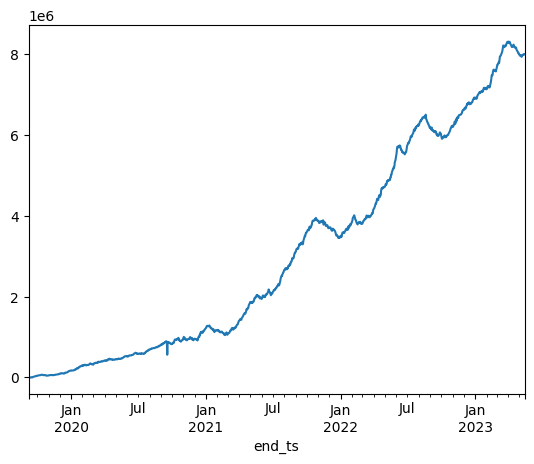

In [13]:
cumul_pnl.plot()